<a href="https://colab.research.google.com/github/santosh2994/AAIC/blob/master/AmazonFineFoodReview/03_Amazon_Fine_Food_Reviews_Analysis_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
#This is used to mount the drive and we can use the data from tha drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.model_selection import train_test_split

#tqdm tells the progress of the query that we are processing
from tqdm import tqdm
import os

from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

In [0]:
# using SQLite Table to read data.
#content/drive
con = sqlite3.connect('/content/drive/My Drive/data/amazon-fine-food-reviews/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 limit 10000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (10000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(9564, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

95.64

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(9564, 10)


1    7976
0    1588
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[100]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[150]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[490]
print(sent_4900)
print("="*50)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
Adzuki ( or Azuki) beans are ment to be used in asian sweets. You can make sweet bean paste by boiling the beans for 30-40 min, (changing the water out at least twice) draining and mashing the beans with sugar.(strain the paste if you do not like the bean skins)  What you get is a paste that can be put on ice cream, fill pasteries or stuff into Mochi Cakes.
love the snack.  wanted to buy a bunch.<p>shipping at amazon is more than the price of the snack.  try ordering a dozen and then look at the shipping price.<p>every link i've tried to this snack takes you back to amazon's exhorbitant shipping rates.<p>another reason to buy your books at overstock.com.  too back they don't carry food as well.
My son had this Jablum roasted and ground coffee brought back from Jamaica and paid a lot for it.  I have drunk blue mountain for years when I can but this was shocking.  It tasted stale when you opened the bag and e

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
Adzuki ( or Azuki) beans are ment to be used in asian sweets. You can make sweet bean paste by boiling the beans for 30-40 min, (changing the water out at least twice) draining and mashing the beans with sugar.(strain the paste if you do not like the bean skins)  What you get is a paste that can be put on ice cream, fill pasteries or stuff into Mochi Cakes.
love the snack.  wanted to buy a bunch.shipping at amazon is more than the price of the snack.  try ordering a dozen and then look at the shipping price.every link i've tried to this snack takes you back to amazon's exhorbitant shipping rates.another reason to buy your books at overstock.com.  too back they don't carry food as well.
My son had this Jablum roasted and ground coffee brought back from Jamaica and paid a lot for it.  I have drunk blue mountain for years when I can but this was shocking.  It tasted stale when you opened the bag and even worse

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

love the snack.  wanted to buy a bunch.<p>shipping at amazon is more than the price of the snack.  try ordering a dozen and then look at the shipping price.<p>every link i have tried to this snack takes you back to amazon is exhorbitant shipping rates.<p>another reason to buy your books at overstock.com.  too back they do not carry food as well.


In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

We have used the Victor fly bait for  seasons.  Can't beat it.  Great product!


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

love the snack wanted to buy a bunch p shipping at amazon is more than the price of the snack try ordering a dozen and then look at the shipping price p every link i have tried to this snack takes you back to amazon is exhorbitant shipping rates p another reason to buy your books at overstock com too back they do not carry food as well 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 9564/9564 [00:02<00:00, 3223.73it/s]


In [0]:
preprocessed_reviews[150]

'love snack wanted buy bunch shipping amazon price snack try ordering dozen look shipping price every link tried snack takes back amazon exhorbitant shipping rates another reason buy books overstock com back not carry food well'

In [0]:
#This is the cleaned data which we will be needing for our processing
final["cleaned_text"] = preprocessed_reviews
final.shape

(9564, 11)

In [0]:
positive_points = final[final['Score'] == 1]
negative_points = final[final['Score'] == 0]
total_points = pd.concat([positive_points, negative_points])
total_points.shape

(9564, 11)

In [0]:
Y = total_points['Score'].values
X = total_points['cleaned_text'].values
print(Y.shape)
print(type(Y))
print(X.shape)
print(type(X))

(9564,)
<class 'numpy.ndarray'>
(9564,)
<class 'numpy.ndarray'>


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [0]:
#BoW
#Splitting the data for training and testing
#Here the data is splitted with train size being 80% of the total data and test size being 20% of the total data
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=12)
#Splitting the data for training and cross-validation dataset
X_train,X_cv,Y_train,Y_cv=train_test_split(X,Y,test_size=0.2,random_state=12)

print('='*100)
print("After splitting")
print(X_train.shape,Y_train.shape)
print(X_cv.shape,Y_cv.shape)
print(X_test.shape,Y_test.shape)

#For vectorizing the text data into vector we will be using the BOW here where here i am using the Bi-Grams ranging from 1 to 2
vectorizer = CountVectorizer(ngram_range=(1,2)) #in scikit-learn
#Here for converting the text to vectorizing we will be using only the X data and not Y data
vectorizer.fit(X_train)
X_train_bow=vectorizer.transform(X_train)
X_cv_bow=vectorizer.transform(X_cv)
X_test_bow=vectorizer.transform(X_test)
print('='*100)
print("After transform")
print(X_train_bow.shape,Y_train.shape)
print(X_cv_bow.shape,Y_cv.shape)
print(X_test_bow.shape,Y_cv.shape)


After splitting
(7651,) (7651,)
(1913,) (1913,)
(1913,) (1913,)
After transform
(7651, 199428) (7651,)
(1913, 199428) (1913,)
(1913, 199428) (1913,)


100%|██████████| 15/15 [00:53<00:00,  3.69s/it]


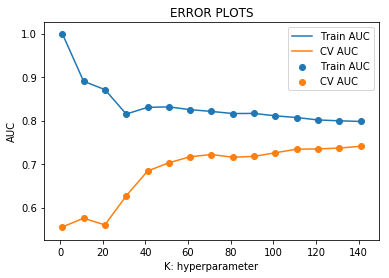

In [0]:
#Here we try to find the best hyperparameter for our model
train_auc = []
cv_auc = []
#For best hyperparameter we are investigating in a range from 1 to 150 by a step of 10
K = list(range(1, 150, 10))
#Using tqdm for tracking the progress
for i in tqdm(K):
  #Defining the model
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='brute')
    #Fitting the vectorized training data of X from BOW and training data of Y
    neigh.fit(X_train_bow, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  neigh.predict_proba(X_train_bow)[:,1]
    Y_cv_pred =  neigh.predict_proba(X_cv_bow)[:,1]
    
    #calculating the roc_auc_score on both the training data and cross validation dataset
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))

#plotting both the scatter plots and ordinary plots using the train AUC and cross validation AUC scores
plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

###Misclassification Error using the cv_auc score that we have obtained

In [0]:
#Optimal value of K: hyper parameter using the CV_auc as cross validation plays a important role
MSE_cv_auc = [1-x for x in cv_auc]
optimal_K_bow = K[MSE_cv_auc.index(min(MSE_cv_auc))]
print("The optimal K:Hyper paramter value using the cross validation - AUC score is : ", optimal_K_bow)

The optimal K:Hyper paramter value using the cross validation - AUC score is :  141


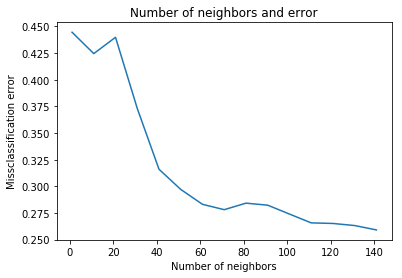

In [0]:
#Plotting the graph using the cv_auc score for the best hyperparameter
plt.plot(K, MSE_cv_auc)
plt.title("Number of neighbors and error")
plt.xlabel("Number of neighbors")
plt.ylabel("Missclassification error")
plt.show()

In [0]:
#Finding the best hyperparameter using the cross validation score available in scikit learn -> model selection
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
neighbors = list(range(80, 100, 2))
#Calculating the cross validation scores using the scoring mechanisam as the accuracy
#Accuracy is not a standard score to believe which is to be noted
cv_score = []
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores = cross_val_score(knn, X_train_bow, Y_train, cv=10, scoring='accuracy')
    cv_score.append(scores.mean()) 

100%|██████████| 10/10 [00:30<00:00,  3.06s/it]


### Missclassification Error using the cv_score

_____________________________________________________________________________________________________
Optimal number of neighbors:  80
_____________________________________________________________________________________________________
Missclassification error for each k values:  [0.168 0.168 0.168 0.168 0.168 0.168 0.168 0.168 0.168 0.168]
_____________________________________________________________________________________________________


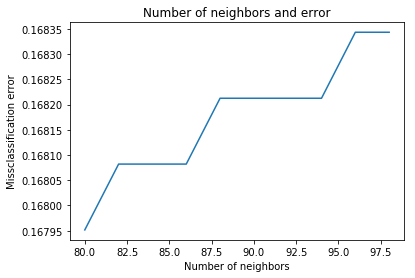

In [0]:
#Mis classification can be termed as the error that has been plotted after obtaining the results of the cross validation scores
MSE = [1 - x for x in cv_score]
optimal_k1 = neighbors[MSE.index(min(MSE))]
print("_" * 101)
print("Optimal number of neighbors: ", optimal_k1)
print("_" * 101)
print("Missclassification error for each k values: ", np.round(MSE, 3))
print("_" * 101)

plt.plot(neighbors, MSE)
plt.title("Number of neighbors and error")
plt.xlabel("Number of neighbors")
plt.ylabel("Missclassification error")
plt.show()

In [0]:
#Now applying the KNN model using the optimal K value hyper parameter using the brute force algorithm by taking the hyperparameter from the cv_auc score
optimal_model = KNeighborsClassifier(n_neighbors=optimal_K_bow,algorithm='brute')
optimal_model.fit(X_train_bow, Y_train)
prediction = optimal_model.predict(X_test_bow)

AUC test score for the BOW :  0.740887194309493


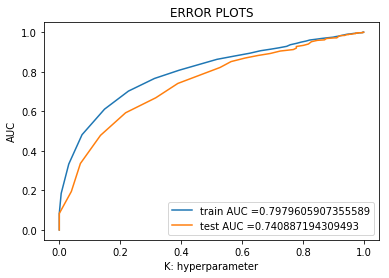

In [0]:
#calculating the metrics for the confusion matrix TPR and FPR
#calculating the TPR and FPR on training dataset
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(X_train_bow)[:,1])
#calculating the TPR and FPR on test dataset
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(X_test_bow)[:,1])
AUC1=str(auc(test_fpr, test_tpr))
print("AUC test score for the BOW : ",AUC1)

#plotting the graph
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

## Calculating the Accuracy

In [0]:
training_accuracy = optimal_model.score(X_train_bow, Y_train)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(Y_test, prediction)
test_error = 1 - test_accuracy


print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)

_____________________________________________________________________________________________________
Training Accuracy:  0.8315252908116586
Train Error:  0.1684747091883414
Test Accuracy:  0.8421327757449033
Test Error:  0.1578672242550967
_____________________________________________________________________________________________________


## Confusion Matrix

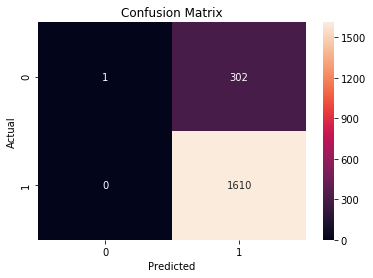

_____________________________________________________________________________________________________


In [0]:
import seaborn as sb
#calculating the confusion matrix between the TPR and the FPR
conf_matrix = confusion_matrix(Y_test, optimal_model.predict(X_test_bow))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

In [0]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       1.00      0.00      0.01       303
           1       0.84      1.00      0.91      1610

    accuracy                           0.84      1913
   macro avg       0.92      0.50      0.46      1913
weighted avg       0.87      0.84      0.77      1913



### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=5)
tf_idf_vect.fit(X_train)
X_train_tfidf= tf_idf_vect.transform(X_train)
X_cv_tfidf=tf_idf_vect.transform(X_cv)
X_test_tfidf=tf_idf_vect.transform(X_test)

100%|██████████| 40/40 [02:24<00:00,  4.01s/it]


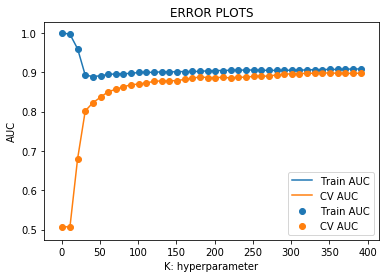

In [0]:
train_auc = []
cv_auc = []
K = list(range(1, 400, 10))
for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='brute')
    neigh.fit(X_train_tfidf, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  neigh.predict_proba(X_train_tfidf)[:,1]
    Y_cv_pred =  neigh.predict_proba(X_cv_tfidf)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
neighbors = list(range(151, 400,10))
cv_score = []
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores = cross_val_score(knn, X_train_tfidf, Y_train, cv=10, scoring='accuracy')
    cv_score.append(scores.mean()) 

100%|██████████| 25/25 [01:11<00:00,  2.93s/it]


_____________________________________________________________________________________________________
Optimal number of neighbors:  151
_____________________________________________________________________________________________________
Missclassification error for each k values:  [0.167 0.167 0.167 0.167 0.167 0.167 0.168 0.168 0.168 0.168 0.168 0.168
 0.168 0.168 0.168 0.168 0.168 0.168 0.168 0.168 0.168 0.168 0.168 0.168
 0.168]
_____________________________________________________________________________________________________


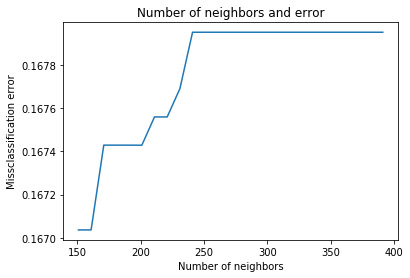

In [0]:
MSE = [1 - x for x in cv_score]
optimal_k2 = neighbors[MSE.index(min(MSE))]
print("_" * 101)
print("Optimal number of neighbors: ", optimal_k2)
print("_" * 101)
print("Missclassification error for each k values: ", np.round(MSE, 3))
print("_" * 101)

plt.plot(neighbors, MSE)
plt.title("Number of neighbors and error")
plt.xlabel("Number of neighbors")
plt.ylabel("Missclassification error")
plt.show()

In [0]:
optimal_model = KNeighborsClassifier(n_neighbors=optimal_k2, algorithm='brute')
optimal_model.fit(X_train_tfidf, Y_train)
prediction = optimal_model.predict(X_test_tfidf)

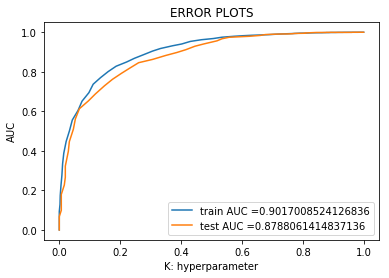

In [0]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(X_test_tfidf)[:,1])
AUC2=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
training_accuracy = optimal_model.score(X_train_tfidf, Y_train)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(Y_test, prediction)
test_error = 1 - test_accuracy


print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)

_____________________________________________________________________________________________________
Training Accuracy:  0.8329630113710627
Train Error:  0.16703698862893734
Test Accuracy:  0.8421327757449033
Test Error:  0.1578672242550967
_____________________________________________________________________________________________________


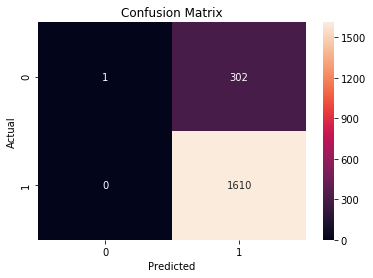

_____________________________________________________________________________________________________


In [0]:
import seaborn as sb
conf_matrix = confusion_matrix(Y_test, optimal_model.predict(X_test_tfidf))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

In [0]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       1.00      0.00      0.01       303
           1       0.84      1.00      0.91      1610

    accuracy                           0.84      1913
   macro avg       0.92      0.50      0.46      1913
weighted avg       0.87      0.84      0.77      1913



### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [0]:
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

# this line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  4991
sample words  ['ok', 'guess', 'bag', 'pound', 'salt', 'find', 'away', 'piece', 'taste', 'somewhat', 'decent', 'also', 'no', 'matter', 'set', 'microwave', 'little', 'burn', 'pieces', 'not', 'even', 'getting', 'whole', 'lot', 'one', 'actually', 'saves', 'basil', 'cilantro', 'extra', 'week', 'two', 'thats', 'enough', 'reason', 'buy', 'would', 'last', 'couple', 'days', 'toss', 'money', 'trip', 'market', 'stuff', 'list', 'ingredients', 'eat', 'anything', 'unless']


In [0]:
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|██████████| 7651/7651 [00:05<00:00, 1317.37it/s]

(7651, 50)
[ 0.55565886  0.36073021 -0.25484449 -0.63297493  0.88485064  0.58745281
 -0.49462734  0.40349941  0.61135925 -0.55191089 -0.33516306  0.18828971
  0.2237699   0.06111992 -0.2985812   0.33899397  0.54943998  0.67041808
  0.16938873 -0.37288465  0.41661672 -0.1806635  -0.08115518 -0.11952712
  0.56340237  0.07067574  0.61201748  0.20849428  0.2391278   0.50589304
  0.6733159   0.03670748 -0.04834856 -0.10481299 -0.10052461  0.10264153
 -0.62001864 -0.37440389  0.12379045 -0.68117226  0.40614625 -0.16215666
  0.49071604  0.16001917  0.20309052 -0.03639025 -0.62980225  0.28183539
 -0.43410546  0.17039272]


In [0]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|██████████| 1913/1913 [00:01<00:00, 1230.37it/s]

(1913, 50)
[ 0.28858792  0.37858321 -0.12544506 -0.56509752  0.76168258  0.32876971
 -0.43718037  0.38966323  0.55431691 -0.82196037 -0.39892155  0.04997526
 -0.08602379  0.17722039 -0.21239705  0.20358674  0.35966479  0.60874934
  0.20076793 -0.43223627  0.40745849 -0.22756575 -0.0557838   0.09848863
  0.45509606  0.04181786  0.46985418  0.25304826  0.09987237  0.35565114
  0.66837579  0.04476445 -0.04276118 -0.10122381 -0.07767435  0.01714024
 -0.48282704 -0.56370069 -0.02358113 -0.71599302  0.23756929 -0.14163785
  0.51932034  0.16756623  0.13181796 -0.1157634  -0.6062095   0.29229909
 -0.30290711  0.2024933 ]


In [0]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|██████████| 1913/1913 [00:01<00:00, 1192.95it/s]

(1913, 50)
[ 0.28858792  0.37858321 -0.12544506 -0.56509752  0.76168258  0.32876971
 -0.43718037  0.38966323  0.55431691 -0.82196037 -0.39892155  0.04997526
 -0.08602379  0.17722039 -0.21239705  0.20358674  0.35966479  0.60874934
  0.20076793 -0.43223627  0.40745849 -0.22756575 -0.0557838   0.09848863
  0.45509606  0.04181786  0.46985418  0.25304826  0.09987237  0.35565114
  0.66837579  0.04476445 -0.04276118 -0.10122381 -0.07767435  0.01714024
 -0.48282704 -0.56370069 -0.02358113 -0.71599302  0.23756929 -0.14163785
  0.51932034  0.16756623  0.13181796 -0.1157634  -0.6062095   0.29229909
 -0.30290711  0.2024933 ]


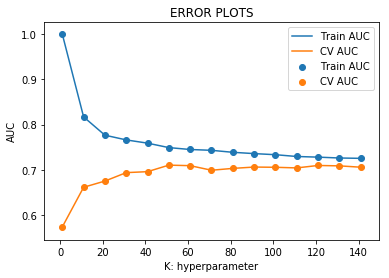

In [0]:
train_auc = []
cv_auc = []
K = list(range(1,150,10))
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='brute')
    neigh.fit(sent_vectors_train, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  neigh.predict_proba(sent_vectors_train)[:,1]
    Y_cv_pred =  neigh.predict_proba(sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
neighbors = list(range(31,45, 2))
cv_score = []
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores = cross_val_score(knn, sent_vectors_train, Y_train, cv=10, scoring='f1')
    cv_score.append(scores.mean())

100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


_____________________________________________________________________________________________________
Optimal number of neighbors:  39
_____________________________________________________________________________________________________
Missclassification error for each k values:  [0.092 0.092 0.092 0.092 0.092 0.092 0.092]
_____________________________________________________________________________________________________


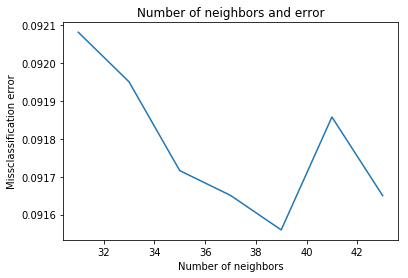

In [0]:
MSE = [1 - x for x in cv_score]
optimal_k3 = neighbors[MSE.index(min(MSE))]
print("_" * 101)
print("Optimal number of neighbors: ", optimal_k3)
print("_" * 101)
print("Missclassification error for each k values: ", np.round(MSE, 3))
print("_" * 101)

plt.plot(neighbors, MSE)
plt.title("Number of neighbors and error")
plt.xlabel("Number of neighbors")
plt.ylabel("Missclassification error")
plt.show()

In [0]:
optimal_model = KNeighborsClassifier(n_neighbors=optimal_k3, algorithm='brute')
optimal_model.fit(sent_vectors_train, Y_train)
prediction = optimal_model.predict(sent_vectors_test)

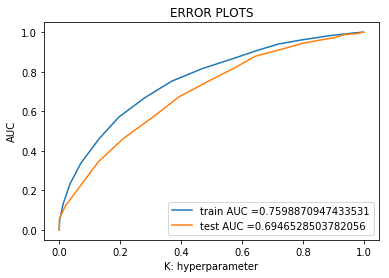

In [0]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(sent_vectors_test)[:,1])
AUC3=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
training_accuracy = optimal_model.score(sent_vectors_train, Y_train)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(Y_test, prediction)
test_error = 1 - test_accuracy


print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)

_____________________________________________________________________________________________________
Training Accuracy:  0.8334858188472095
Train Error:  0.16651418115279049
Test Accuracy:  0.8421327757449033
Test Error:  0.1578672242550967
_____________________________________________________________________________________________________


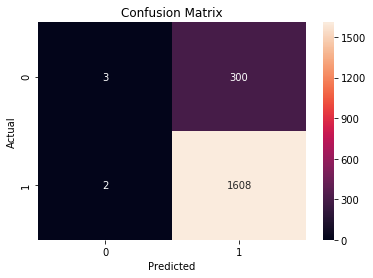

_____________________________________________________________________________________________________


In [0]:
import seaborn as sb
conf_matrix = confusion_matrix(Y_test, optimal_model.predict(sent_vectors_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

In [0]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.60      0.01      0.02       303
           1       0.84      1.00      0.91      1610

    accuracy                           0.84      1913
   macro avg       0.72      0.50      0.47      1913
weighted avg       0.80      0.84      0.77      1913



### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████| 7651/7651 [00:42<00:00, 180.44it/s]


In [0]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████| 1913/1913 [00:10<00:00, 176.89it/s]


In [0]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 1913/1913 [00:10<00:00, 176.42it/s]


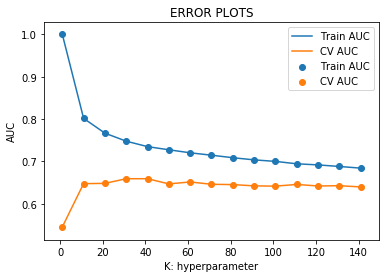

In [0]:
train_auc = []
cv_auc = []
K = list(range(1,150,10))
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='brute')
    neigh.fit(tfidf_sent_vectors_train, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  neigh.predict_proba(tfidf_sent_vectors_train)[:,1]
    Y_cv_pred =  neigh.predict_proba(tfidf_sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
neighbors = list(range(21, 50, 2))
cv_score = []
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores = cross_val_score(knn, tfidf_sent_vectors_train, Y_train, cv=10, scoring='f1')
    cv_score.append(scores.mean())

100%|██████████| 15/15 [00:26<00:00,  1.80s/it]


_____________________________________________________________________________________________________
Optimal number of neighbors:  45
_____________________________________________________________________________________________________
Missclassification error for each k values:  [0.093 0.092 0.092 0.092 0.092 0.091 0.092 0.092 0.092 0.091 0.092 0.091
 0.091 0.091 0.091]
_____________________________________________________________________________________________________


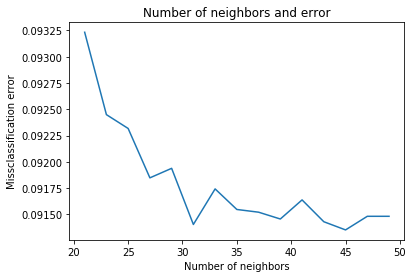

In [0]:
MSE = [1 - x for x in cv_score]
optimal_k4 = neighbors[MSE.index(min(MSE))]
print("_" * 101)
print("Optimal number of neighbors: ", optimal_k4)
print("_" * 101)
print("Missclassification error for each k values: ", np.round(MSE, 3))
print("_" * 101)

plt.plot(neighbors, MSE)
plt.title("Number of neighbors and error")
plt.xlabel("Number of neighbors")
plt.ylabel("Missclassification error")
plt.show()

In [0]:
optimal_model = KNeighborsClassifier(n_neighbors=optimal_k4, algorithm='brute')
optimal_model.fit(tfidf_sent_vectors_train, Y_train)
prediction = optimal_model.predict(tfidf_sent_vectors_test)

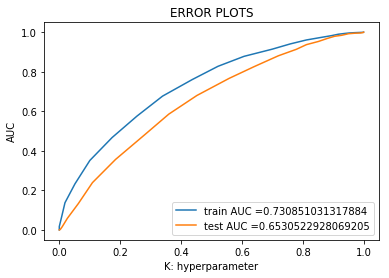

In [0]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(tfidf_sent_vectors_test)[:,1])
AUC4=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
training_accuracy = optimal_model.score(tfidf_sent_vectors_train, Y_train)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(Y_test, prediction)
test_error = 1 - test_accuracy


print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)

import seaborn as sb

_____________________________________________________________________________________________________
Training Accuracy:  0.8329630113710627
Train Error:  0.16703698862893734
Test Accuracy:  0.8405645582854155
Test Error:  0.15943544171458446
_____________________________________________________________________________________________________


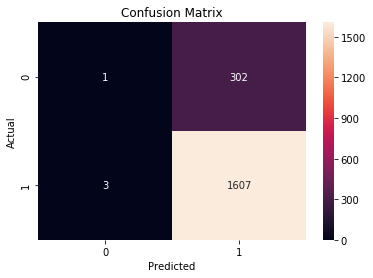

_____________________________________________________________________________________________________


In [0]:
conf_matrix = confusion_matrix(Y_test, optimal_model.predict(tfidf_sent_vectors_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

In [0]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.25      0.00      0.01       303
           1       0.84      1.00      0.91      1610

    accuracy                           0.84      1913
   macro avg       0.55      0.50      0.46      1913
weighted avg       0.75      0.84      0.77      1913



## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [0]:
data_pos1 = final[final["Score"] == 1].sample(n = 1000)
data_neg1 = final[final["Score"] == 0].sample(n = 1000)
final2 = pd.concat([data_pos1, data_neg1])
final2.shape

B = final2['Score'].values
A = final2['cleaned_text'].values
print(B.shape)
print(type(B))
print(A.shape)
print(type(B))

(2000,)
<class 'numpy.ndarray'>
(2000,)
<class 'numpy.ndarray'>


In [0]:
A_train,A_test,B_train,B_test=train_test_split(A,B,test_size=0.2,random_state=12)
A_train,A_cv,B_train,B_cv=train_test_split(A,B,test_size=0.2,random_state=12)
print('='*100)
print("After splitting")
print(A_train.shape,B_train.shape)
print(A_cv.shape,B_cv.shape)
print(A_test.shape,B_test.shape)

After splitting
(1600,) (1600,)
(400,) (400,)
(400,) (400,)


In [0]:
vectorizer=CountVectorizer(min_df=10, max_features=500)
vectorizer=vectorizer.fit(A_train)
A_train_bow_kdtree=vectorizer.transform(A_train)
A_cv_bow_kdtree=vectorizer.transform(A_cv)
A_test_bow_kdtree=vectorizer.transform(A_test)
print('='*100)
print("After transform")
print(A_train_bow_kdtree.shape,B_train.shape)
print(A_cv_bow_kdtree.shape,B_cv.shape)
print(A_test_bow_kdtree.shape,B_cv.shape)

After transform
(1600, 500) (1600,)
(400, 500) (400,)
(400, 500) (400,)


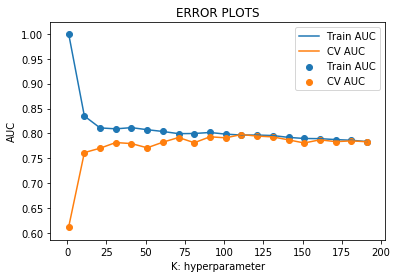

In [0]:
train_auc = []
cv_auc = []
K = list(range(1,200,10))
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')
    neigh.fit(A_train_bow_kdtree.todense(), B_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    B_train_pred =  neigh.predict_proba(A_train_bow_kdtree.todense())[:,1]
    B_cv_pred =  neigh.predict_proba(A_cv_bow_kdtree.todense())[:,1]
    
    train_auc.append(roc_auc_score(B_train,B_train_pred))
    cv_auc.append(roc_auc_score(B_cv, B_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
neighbors = list(range(31, 71, 2))
cv_score = []
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores = cross_val_score(knn, A_train_bow_kdtree.todense(), B_train, cv=10, scoring='accuracy')
    cv_score.append(scores.mean()) 

100%|██████████| 20/20 [00:46<00:00,  2.31s/it]


_____________________________________________________________________________________________________
Optimal number of neighbors:  55
_____________________________________________________________________________________________________
Missclassification error for each k values:  [0.291 0.289 0.292 0.301 0.289 0.29  0.287 0.285 0.289 0.285 0.285 0.284
 0.282 0.287 0.287 0.285 0.289 0.294 0.286 0.286]
_____________________________________________________________________________________________________


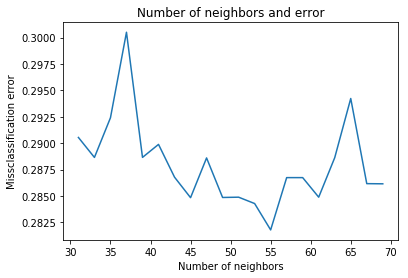

In [0]:
MSE = [1 - x for x in cv_score]
optimal_k5 = neighbors[MSE.index(min(MSE))]
print("_" * 101)
print("Optimal number of neighbors: ", optimal_k5)
print("_" * 101)
print("Missclassification error for each k values: ", np.round(MSE, 3))
print("_" * 101)

plt.plot(neighbors, MSE)
plt.title("Number of neighbors and error")
plt.xlabel("Number of neighbors")
plt.ylabel("Missclassification error")
plt.show()

In [0]:
optimal_model = KNeighborsClassifier(n_neighbors=optimal_k5,algorithm='kd_tree')
optimal_model.fit(A_train_bow_kdtree.todense(), B_train)
prediction = optimal_model.predict(A_test_bow_kdtree.todense())

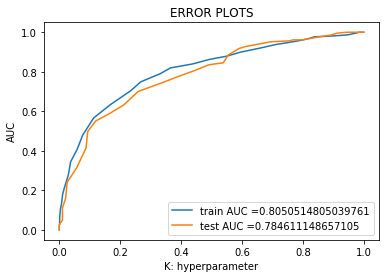

In [0]:
train_fpr, train_tpr, thresholds = roc_curve(B_train, optimal_model.predict_proba(A_train_bow_kdtree.todense())[:,1])
test_fpr, test_tpr, thresholds = roc_curve(B_test, optimal_model.predict_proba(A_test_bow_kdtree.todense())[:,1])
AUC5=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
training_accuracy = optimal_model.score(A_train_bow_kdtree.todense(), B_train)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(B_test, prediction)
test_error = 1 - test_accuracy


print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)

_____________________________________________________________________________________________________
Training Accuracy:  0.740625
Train Error:  0.259375
Test Accuracy:  0.72
Test Error:  0.28
_____________________________________________________________________________________________________


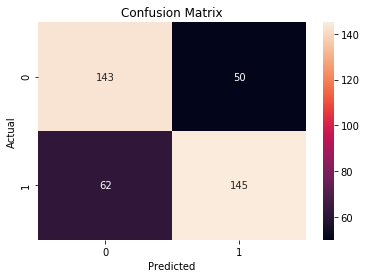

_____________________________________________________________________________________________________


In [0]:
import seaborn as sb
conf_matrix = confusion_matrix(B_test, optimal_model.predict(A_test_bow_kdtree.todense()))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

In [0]:
from sklearn.metrics import classification_report
print(classification_report(B_test, prediction))

              precision    recall  f1-score   support

           0       0.70      0.74      0.72       193
           1       0.74      0.70      0.72       207

    accuracy                           0.72       400
   macro avg       0.72      0.72      0.72       400
weighted avg       0.72      0.72      0.72       400



### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [0]:
# Please write all the code with proper documentation
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_df=100)
tf_idf_vect.fit(A_train)
A_train_tfidf =tf_idf_vect.transform(A_train)
A_cv_tfidf=tf_idf_vect.transform(A_cv)
A_test_tfidf=tf_idf_vect.transform(A_test)
print(A_train_tfidf.shape)

(1600, 2349)


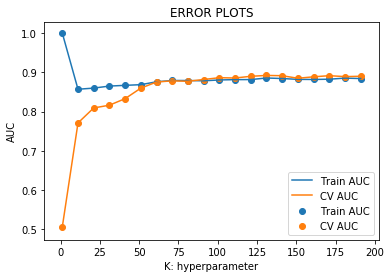

In [0]:
train_auc = []
cv_auc = []
K = list(range(1,200,10))
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')
    neigh.fit(A_train_tfidf.todense(), B_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    B_train_pred =  neigh.predict_proba(A_train_tfidf.todense())[:,1]
    B_cv_pred =  neigh.predict_proba(A_cv_tfidf.todense())[:,1]
    
    train_auc.append(roc_auc_score(B_train,B_train_pred))
    cv_auc.append(roc_auc_score(B_cv, B_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
from sklearn.metrics import accuracy_score
neighbors = list(range(109,125,2))
cv_score = []
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores = cross_val_score(knn, A_train_tfidf.todense(), B_train, cv=3, scoring='accuracy')
    cv_score.append(scores.mean())

100%|██████████| 8/8 [01:04<00:00,  8.05s/it]


_____________________________________________________________________________________________________
Optimal number of neighbors:  119
_____________________________________________________________________________________________________
Missclassification error for each k values:  [0.241 0.239 0.236 0.234 0.229 0.228 0.236 0.231]
_____________________________________________________________________________________________________


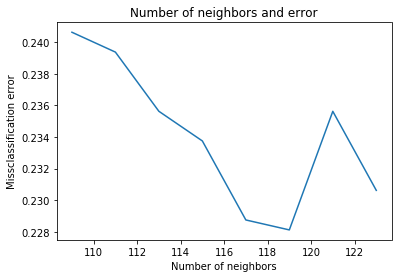

In [0]:
MSE = [1 - x for x in cv_score]
optimal_k6 = neighbors[MSE.index(min(MSE))]
print("_" * 101)
print("Optimal number of neighbors: ", optimal_k6)
print("_" * 101)
print("Missclassification error for each k values: ", np.round(MSE, 3))
print("_" * 101)

plt.plot(neighbors, MSE)
plt.title("Number of neighbors and error")
plt.xlabel("Number of neighbors")
plt.ylabel("Missclassification error")
plt.show()

In [0]:
optimal_model = KNeighborsClassifier(n_neighbors=optimal_k6, algorithm='kd_tree')
optimal_model.fit(A_train_tfidf.todense(), B_train)
prediction = optimal_model.predict(A_test_tfidf.todense())

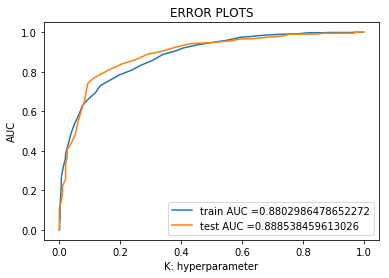

In [0]:
train_fpr, train_tpr, thresholds = roc_curve(B_train, optimal_model.predict_proba(A_train_tfidf.todense())[:,1])
test_fpr, test_tpr, thresholds = roc_curve(B_test, optimal_model.predict_proba(A_test_tfidf.todense())[:,1])
AUC6=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
training_accuracy = optimal_model.score(A_train_tfidf.todense(), B_train)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(B_test, prediction)
test_error = 1 - test_accuracy


print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)

_____________________________________________________________________________________________________
Training Accuracy:  0.785
Train Error:  0.21499999999999997
Test Accuracy:  0.8175
Test Error:  0.1825
_____________________________________________________________________________________________________


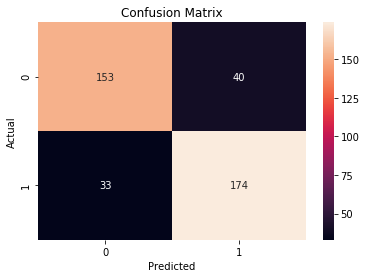

_____________________________________________________________________________________________________


In [0]:
import seaborn as sb
conf_matrix = confusion_matrix(B_test, optimal_model.predict(A_test_tfidf.todense()))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

In [0]:
from sklearn.metrics import classification_report
print(classification_report(B_test, prediction))

              precision    recall  f1-score   support

           0       0.82      0.79      0.81       193
           1       0.81      0.84      0.83       207

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.82      0.82      0.82       400



### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

In [0]:
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

# this line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  4991
sample words  ['ok', 'guess', 'bag', 'pound', 'salt', 'find', 'away', 'piece', 'taste', 'somewhat', 'decent', 'also', 'no', 'matter', 'set', 'microwave', 'little', 'burn', 'pieces', 'not', 'even', 'getting', 'whole', 'lot', 'one', 'actually', 'saves', 'basil', 'cilantro', 'extra', 'week', 'two', 'thats', 'enough', 'reason', 'buy', 'would', 'last', 'couple', 'days', 'toss', 'money', 'trip', 'market', 'stuff', 'list', 'ingredients', 'eat', 'anything', 'unless']


In [0]:
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|██████████| 7651/7651 [00:06<00:00, 1271.79it/s]

(7651, 50)
[ 0.55749662  0.40299206 -0.16792599 -0.62984893  0.84316368  0.57737975
 -0.53565875  0.40743601  0.63723999 -0.55679536 -0.37468497  0.21113551
  0.20535012  0.19072537 -0.29175795  0.30440723  0.49796028  0.68230848
  0.12142936 -0.37897957  0.35885432 -0.21535725 -0.06070714 -0.14142932
  0.55763679  0.07306015  0.5944246   0.13881688  0.22327934  0.50195423
  0.65701975  0.00372685 -0.08446666 -0.16995333 -0.00251605  0.04160312
 -0.61314034 -0.38962909  0.12770875 -0.69073283  0.46151887 -0.17511684
  0.47548964  0.1799761   0.15651182 -0.0596825  -0.64487604  0.27439113
 -0.43942618  0.15119319]


In [0]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|██████████| 1913/1913 [00:01<00:00, 1191.80it/s]

(1913, 50)
[ 0.24561684  0.41333252 -0.12944511 -0.52879344  0.78411597  0.34927873
 -0.47129608  0.34452876  0.58771408 -0.82846326 -0.41844683  0.1026214
 -0.07977498  0.17692381 -0.21673     0.20233962  0.35756979  0.57754197
  0.22323643 -0.41527289  0.38153869 -0.20052586 -0.07924125  0.07680494
  0.45361515  0.08292547  0.45311212  0.23820607  0.13204097  0.35713661
  0.6189046   0.02055765 -0.01850531 -0.15912046 -0.05363013  0.05744211
 -0.47895778 -0.55910773  0.0096994  -0.73380325  0.27754957 -0.17567971
  0.54969352  0.17492264  0.07725043 -0.14654981 -0.60422044  0.26861482
 -0.2966177   0.16070025]


In [0]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|██████████| 1913/1913 [00:01<00:00, 1213.40it/s]

(1913, 50)
[ 0.24561684  0.41333252 -0.12944511 -0.52879344  0.78411597  0.34927873
 -0.47129608  0.34452876  0.58771408 -0.82846326 -0.41844683  0.1026214
 -0.07977498  0.17692381 -0.21673     0.20233962  0.35756979  0.57754197
  0.22323643 -0.41527289  0.38153869 -0.20052586 -0.07924125  0.07680494
  0.45361515  0.08292547  0.45311212  0.23820607  0.13204097  0.35713661
  0.6189046   0.02055765 -0.01850531 -0.15912046 -0.05363013  0.05744211
 -0.47895778 -0.55910773  0.0096994  -0.73380325  0.27754957 -0.17567971
  0.54969352  0.17492264  0.07725043 -0.14654981 -0.60422044  0.26861482
 -0.2966177   0.16070025]


100%|██████████| 20/20 [01:14<00:00,  4.51s/it]


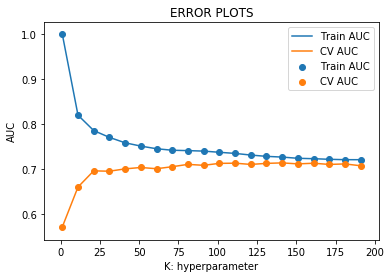

In [0]:
train_auc = []
cv_auc = []
K = list(range(1,200,10))
for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')
    neigh.fit(sent_vectors_train, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  neigh.predict_proba(sent_vectors_train)[:,1]
    Y_cv_pred =  neigh.predict_proba(sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
neighbors = list(range(9,35,2))
cv_score = []
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores = cross_val_score(knn, sent_vectors_train, Y_train, cv=10, scoring='f1')
    cv_score.append(scores.mean())  

100%|██████████| 13/13 [00:31<00:00,  2.56s/it]


_____________________________________________________________________________________________________
Optimal number of neighbors:  33
_____________________________________________________________________________________________________
Missclassification error for each k values:  [0.097 0.096 0.094 0.094 0.093 0.094 0.093 0.093 0.093 0.092 0.092 0.092
 0.091]
_____________________________________________________________________________________________________


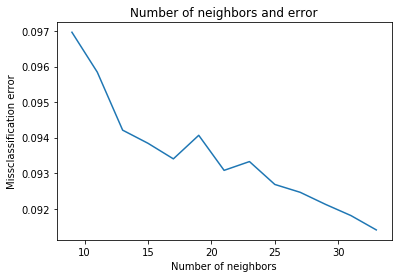

In [0]:
MSE = [1 - x for x in cv_score]
optimal_k7 = neighbors[MSE.index(min(MSE))]
print("_" * 101)
print("Optimal number of neighbors: ", optimal_k7)
print("_" * 101)
print("Missclassification error for each k values: ", np.round(MSE, 3))
print("_" * 101)

plt.plot(neighbors, MSE)
plt.title("Number of neighbors and error")
plt.xlabel("Number of neighbors")
plt.ylabel("Missclassification error")
plt.show()

In [0]:
optimal_model = KNeighborsClassifier(n_neighbors=optimal_k7, algorithm='kd_tree')
optimal_model.fit(sent_vectors_train, Y_train)
prediction = optimal_model.predict(sent_vectors_test)

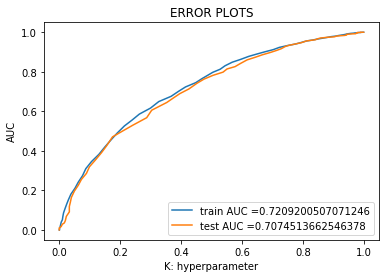

In [0]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, neigh.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, neigh.predict_proba(sent_vectors_test)[:,1])
AUC7=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
training_accuracy = optimal_model.score(sent_vectors_train, Y_train)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(Y_test, prediction)
test_error = 1 - test_accuracy


print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)

_____________________________________________________________________________________________________
Training Accuracy:  0.8344007319304666
Train Error:  0.1655992680695334
Test Accuracy:  0.8410872974385781
Test Error:  0.15891270256142187
_____________________________________________________________________________________________________


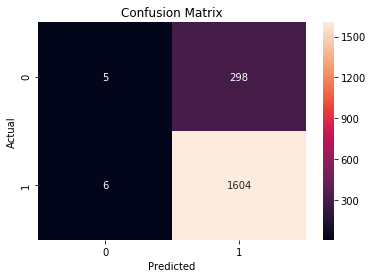

_____________________________________________________________________________________________________


In [0]:
import seaborn as sb
conf_matrix = confusion_matrix(Y_test, optimal_model.predict(sent_vectors_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

In [0]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.45      0.02      0.03       303
           1       0.84      1.00      0.91      1610

    accuracy                           0.84      1913
   macro avg       0.65      0.51      0.47      1913
weighted avg       0.78      0.84      0.77      1913



### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████| 7651/7651 [00:16<00:00, 471.77it/s]


In [0]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████| 1913/1913 [00:04<00:00, 472.08it/s]


In [0]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 1913/1913 [00:04<00:00, 457.31it/s]


100%|██████████| 20/20 [01:14<00:00,  4.52s/it]


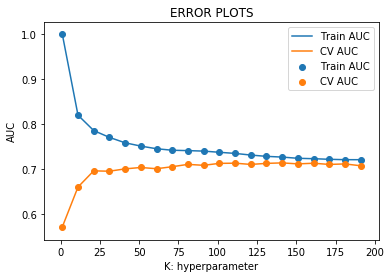

In [0]:
train_auc = []
cv_auc = []
K = list(range(1,200,10))
for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')
    neigh.fit(sent_vectors_train, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  neigh.predict_proba(sent_vectors_train)[:,1]
    Y_cv_pred =  neigh.predict_proba(sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
from sklearn.model_selection import cross_val_score
neighbors = list(range(13, 50, 2))
cv_score = []
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores = cross_val_score(knn, tfidf_sent_vectors_train, Y_train, cv=10, scoring='accuracy')
    cv_score.append(scores.mean()) 

100%|██████████| 19/19 [00:44<00:00,  2.51s/it]


_____________________________________________________________________________________________________
Optimal number of neighbors:  39
_____________________________________________________________________________________________________
Missclassification error for each k values:  [0.175 0.172 0.173 0.172 0.172 0.172 0.171 0.171 0.172 0.173 0.172 0.171
 0.17  0.17  0.17  0.17  0.171 0.17  0.17 ]
_____________________________________________________________________________________________________


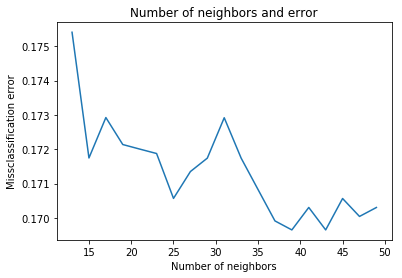

In [0]:
MSE = [1 - x for x in cv_score]
optimal_k8 = neighbors[MSE.index(min(MSE))]
print("_" * 101)
print("Optimal number of neighbors: ", optimal_k8)
print("_" * 101)
print("Missclassification error for each k values: ", np.round(MSE, 3))
print("_" * 101)

plt.plot(neighbors, MSE)
plt.title("Number of neighbors and error")
plt.xlabel("Number of neighbors")
plt.ylabel("Missclassification error")
plt.show()

In [0]:
optimal_model = KNeighborsClassifier(n_neighbors=optimal_k8, algorithm='kd_tree')
optimal_model.fit(tfidf_sent_vectors_train, Y_train)
prediction = optimal_model.predict(tfidf_sent_vectors_test)

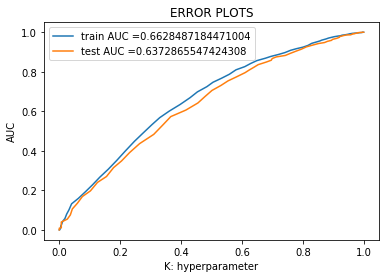

In [0]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, neigh.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, neigh.predict_proba(tfidf_sent_vectors_test)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
training_accuracy = optimal_model.score(tfidf_sent_vectors_train, Y_train)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(Y_test, prediction)
test_error = 1 - test_accuracy


print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)

_____________________________________________________________________________________________________
Training Accuracy:  0.8329630113710627
Train Error:  0.16703698862893734
Test Accuracy:  0.8384736016727653
Test Error:  0.1615263983272347
_____________________________________________________________________________________________________


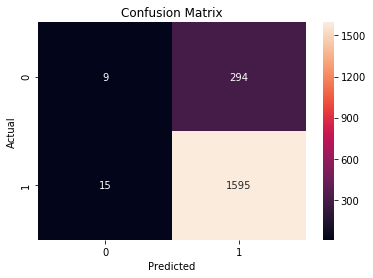

_____________________________________________________________________________________________________


In [0]:
import seaborn as sb
conf_matrix = confusion_matrix(Y_test, optimal_model.predict(tfidf_sent_vectors_test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

In [0]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.38      0.03      0.06       303
           1       0.84      0.99      0.91      1610

    accuracy                           0.84      1913
   macro avg       0.61      0.51      0.48      1913
weighted avg       0.77      0.84      0.78      1913



# [6] Conclusions

In [0]:
from prettytable import PrettyTable
comparison = PrettyTable()
comparison.field_names = ["Vectorizer", "Model", "Hyperparameter", "AUC"]
comparison.add_row(["BOW", 'brute', optimal_k1, np.round(float(AUC1),3)])
comparison.add_row(["TFIDF", 'brute', optimal_k2, np.round(float(AUC2),3)])
comparison.add_row(["AVG W2V", 'brute', optimal_k3, np.round(float(AUC3),3)])
comparison.add_row(["Weighted W2V", 'brute', optimal_k4,np.round(float(AUC4),3)])
comparison.add_row(["BOW", 'kd_tree', optimal_k5, np.round(float(AUC5),3)])
comparison.add_row(["TFIDF", 'kd_tree', optimal_k6, np.round(float(AUC6),3)])
comparison.add_row(["AVG W2V", 'kd_tree', optimal_k7, np.round(float(AUC7),3)])
comparison.add_row(["Weighted W2V", 'kd_tree', optimal_k8, np.round(float(AUC8),3)])
print(comparison)

+--------------+---------+----------------+-------+
|  Vectorizer  |  Model  | Hyperparameter |  AUC  |
+--------------+---------+----------------+-------+
|     BOW      |  brute  |       80       | 0.741 |
|    TFIDF     |  brute  |      151       | 0.879 |
|   AVG W2V    |  brute  |       39       | 0.695 |
| Weighted W2V |  brute  |       45       | 0.653 |
|     BOW      | kd_tree |       55       | 0.785 |
|    TFIDF     | kd_tree |      119       | 0.889 |
|   AVG W2V    | kd_tree |       33       | 0.707 |
| Weighted W2V | kd_tree |       39       | 0.637 |
+--------------+---------+----------------+-------+
